In [1]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib
import pylab as plb
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from scipy import asarray as ar,exp
import warnings
import math
warnings.filterwarnings('ignore')
from IPython.display import Markdown as md


## Relative folder

In [2]:
home = expanduser("~")
datafolder=home+'/Desktop/mrk79/cubes/'  #The folder containing your .fits file
datafolder

'/home/apostolis/Desktop/mrk79/cubes/'

## Open fits file

In [3]:
mrk79_file='COcube.fits' #.fits file name
mrk79_fits=fits.open(datafolder+mrk79_file)[0]

## Fits header

In [4]:
mrk79_header=mrk79_fits.header
mrk79_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   97                                                  
NAXIS2  =                   97                                                  
NAXIS3  =                  190                                                  
NAXIS4  =                    1                                                  
DATAMIN = -0.6655395496637E-02         /                                        
DATAMAX =  0.2891516312957E-01         /                                        
BUNIT   = 'Jy/beam     '               /                                        
CTYPE1  = 'RA---ARC    '               /                                        
CRVAL1  =  0.1156366666667E+03         /                                        
CDELT1  = -0.1731111137690E-

## Data

In [5]:
mrk79_data=mrk79_fits.data
print(f'Shape of data is {mrk79_data.shape}, so this is not a cube, it has an extra dimension without a reason')
mrk79_data=mrk79_data[0]
print(f'Shape of data is {mrk79_data.shape}, seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)')

Shape of data is (1, 190, 97, 97), so this is not a cube, it has an extra dimension without a reason
Shape of data is (190, 97, 97), seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)


### Calculate the coordinates
From the header the z coordinate has velocity dimensions ```CTYPE3  = 'VRAD'``` in km/s ```CUNIT3  = 'km/s'```

From the header the x,y coordinates has RA/DEC dimensions ```CTYPE1  = 'RA---ARC'```,```CTYPE2  = 'DEC--ARC'``` in degrees```CUNIT1  = 'deg'```

In [6]:
dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s

ydec=np.linspace(-mrk79_data.shape[1]*dy/2. +mrk79_header["CRVAL2"],mrk79_data.shape[1]*dy/2.+mrk79_header["CRVAL2"],mrk79_header['NAXIS2'])
xra=np.linspace(-mrk79_data.shape[2]*dx/2. +mrk79_header["CRVAL1"],mrk79_data.shape[2]*dx/2.+mrk79_header["CRVAL1"],mrk79_header['NAXIS1'])

xx=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])  #velocity channels
global xcen, ycen
xcen=int(mrk79_data.shape[2]/2)
ycen=int(mrk79_data.shape[1]/2)


### Make some plots

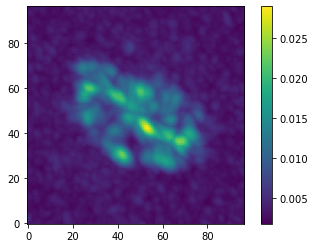

In [7]:
mrk79_max = np.nanmax(mrk79_data,axis=0) #collapse the cube along 0 dimension (velocity) by keeping only the maximum velocities 
plt.imshow(mrk79_max,origin='lower')
plt.colorbar()# Image plot, dimensions are pixels

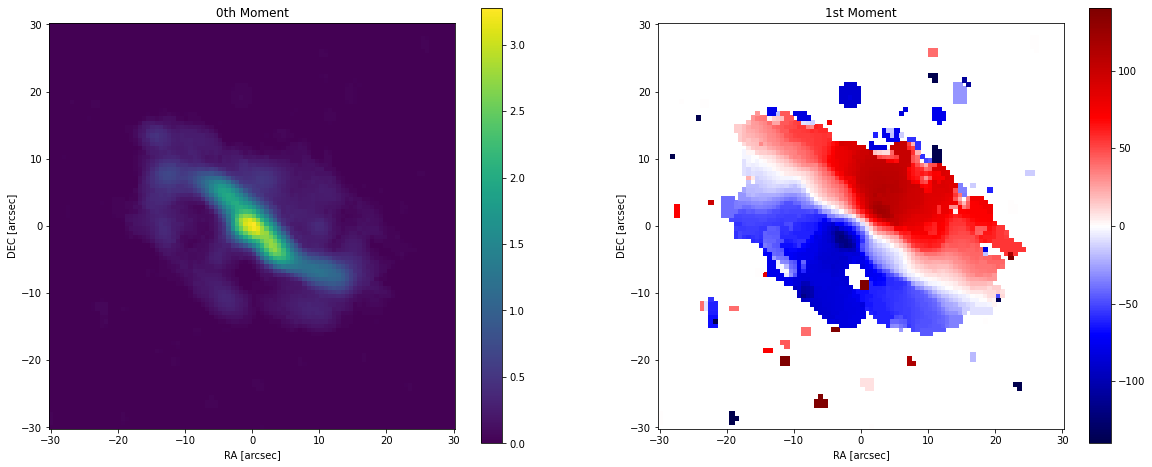

In [8]:
sigma=9.3859574E-4 #noise [Jy/beam]
fig, axes = plt.subplots(1,2,figsize=(20,8))
mrk79_mom0 = np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)*np.abs(dv) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)
vv2=np.linspace(0,0,mrk79_header["NAXIS3"]) 
for i in range(mrk79_header["NAXIS3"]):
    vv2[i]=np.where(-350<=vv[i] and vv[i]<=350,vv[i],0)
mrk79_mom1=np.nansum(vv2[:,None,None]*np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)/(mrk79_mom0/np.abs(dv)) #first moment
p0=axes[0].pcolormesh(xx,yy,mrk79_mom0,vmin=0)
axes[0].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])
p1=axes[1].pcolormesh(xx,yy,mrk79_mom1,vmin=-140, vmax=140,cmap='seismic')
axes[1].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])

### Extra: Calculate the intrinsic dimensions

arcsec to kpc conversion: 0.4630279249450416 kpc / arcsec
distance to mrk79: 99.79205841490912 Mpc


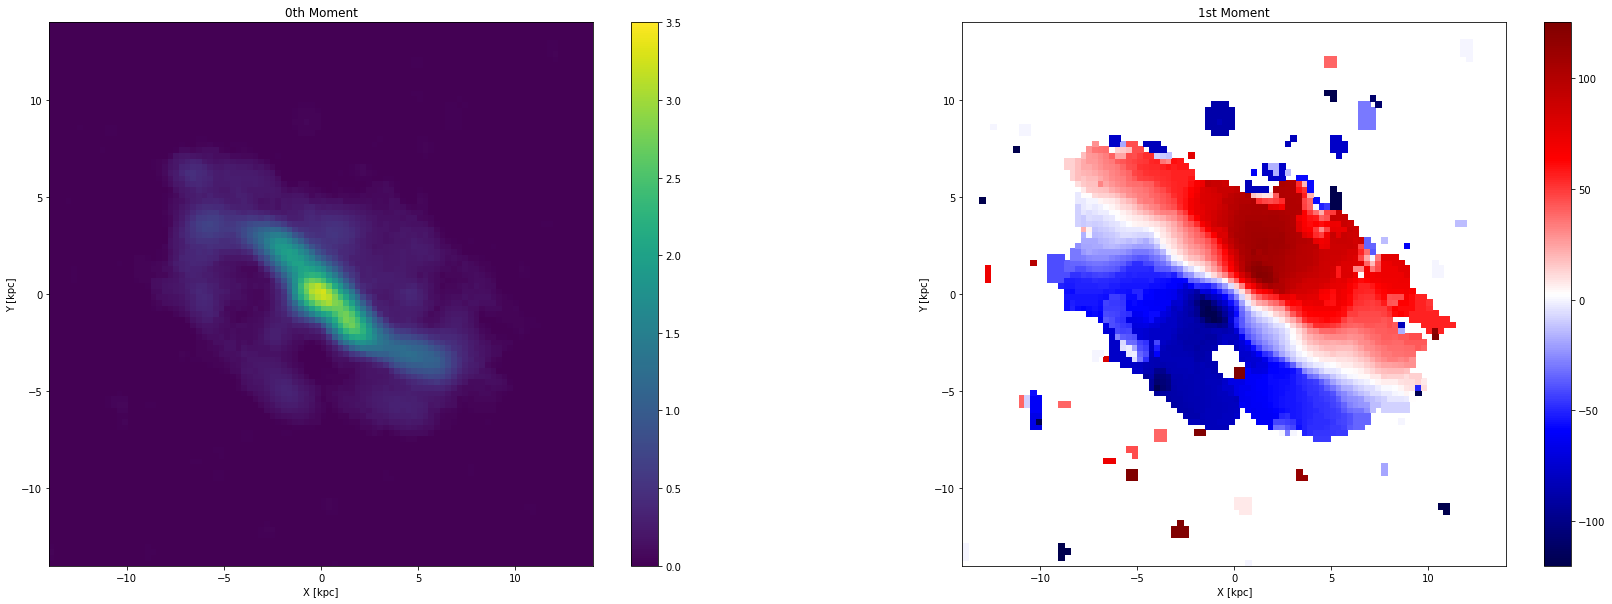

In [9]:
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=67.8, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.02219  #redshift
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
print("arcsec to kpc conversion:",arctokpc)
ak=arctokpc.value
print("distance to mrk79:",D)

xx_kpc=xx*ak
yy_kpc=yy*ak

fig, axes = plt.subplots(1,2,figsize=(30,10))

p0=axes[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0, vmin=-0, vmax=3.5)
axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])
#np.rad2deg(math.acos(2.5/4))
#np.rad2deg(math.asin(np.sqrt(1-(2.5/4)**2)))


## Position Velocity Plots

0.0004341938635838815

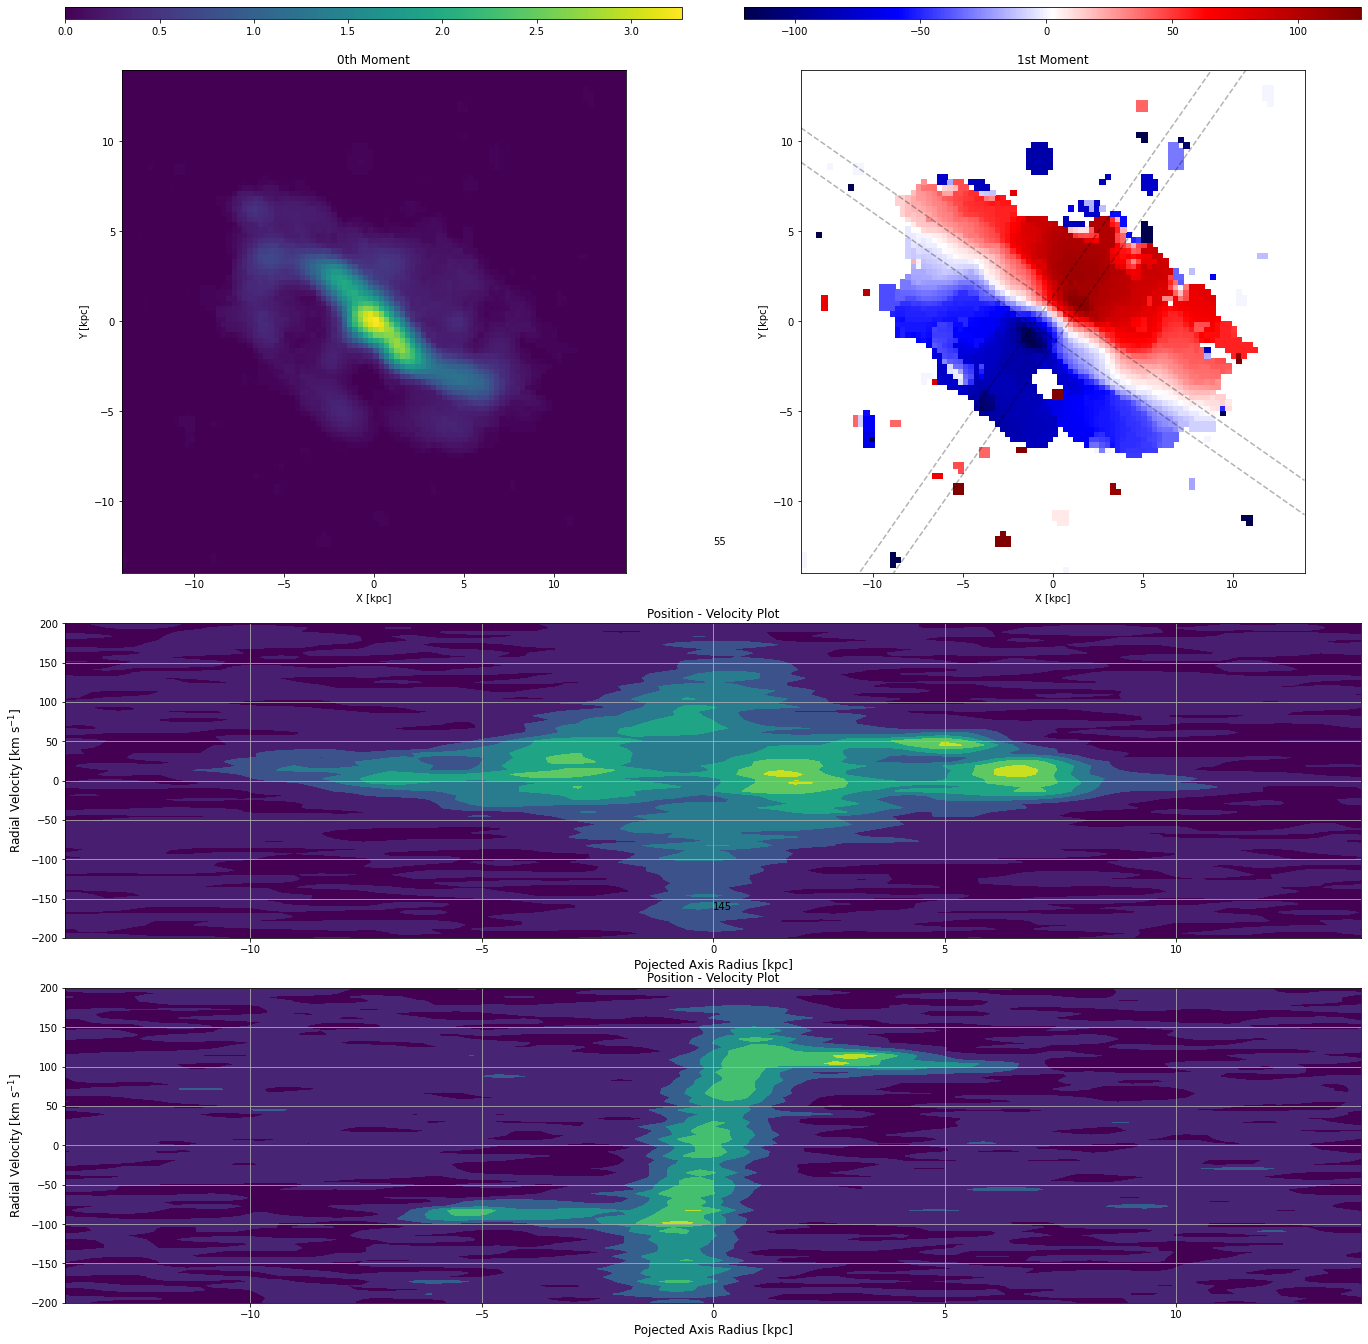

In [10]:
import matplotlib.gridspec as gridspec
#4arcsec X 3.4
papvds = [55,145]
dx_kpc=(dx)*ak #dx in kpc
slit=0.9377271654521E-03*ak*3600 #slit width in kpc
limy=[np.min(yy_kpc),np.max(yy_kpc)]
limv=[-200,200]

Nplots=len(papvds)
Ncubes = 1
fig = plt.figure(figsize=(20,10+5*Nplots))
gs=gridspec.GridSpec(2+Nplots, 2*Ncubes, height_ratios=[0.02,0.8]+[0.5]*Nplots, width_ratios=[0.8,0.8]*Ncubes)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ipx=0
axmom0 = fig.add_subplot(gs[1,ipx])
caxmom0 = fig.add_subplot(gs[0,ipx])
ipx=ipx+1
axmom1 = fig.add_subplot(gs[1,ipx])
caxmom1 = fig.add_subplot(gs[0,ipx])

cm0=axmom0.pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
plt.colorbar(cm0,cax=caxmom0,orientation='horizontal').ax.tick_params(labelsize=10)
axmom0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')  

cm1=axmom1.pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
plt.colorbar(cm1,cax=caxmom1,orientation='horizontal').ax.tick_params(labelsize=10)  
axmom1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')   

ithick = int(round(slit/dx_kpc)) #number of pixels which are going to collapse (inside the slit)
ixc = round(mrk79_data.shape[2]/2) #where is the center in pixels

for j,papvd in enumerate(papvds):
    
    #Create and Plot the Slit(s)
    def yslit_low(x,pa): return slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
    def yslit_high(x,pa): return -slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
    axmom1.plot(xx_kpc,yslit_low(xx_kpc,papvds[j]),'--',alpha=0.3, color='black')
    axmom1.plot(xx_kpc,yslit_high(xx_kpc,papvds[j]),'--',alpha=0.3, color='black')
    axmom1.set(xlim=[np.min(xx_kpc),np.max(xx_kpc)],ylim=[np.min(yy_kpc),np.max(yy_kpc)])   

    axpvd = fig.add_subplot(gs[2+j,:])
    axpvd.text(x=np.mean(limy),y=300,s="{}".format(papvd))
    axpvd.set(title='Position - Velocity Plot')
    axpvd.set_xlabel('Pojected Axis Radius [kpc]',fontsize=12)
    axpvd.set_ylabel(r'Radial Velocity [km s$^{-1}$]',fontsize=12)

    axpvd.set_xlim(limy)
    axpvd.set_ylim(limv)
    axpvd.grid(True)
    
    #Create the Position-Velocity Graph
    rotcube=ndimage.interpolation.rotate(mrk79_data,papvd+180,axes=(2,1),reshape=False) #rotate the cube along 0 dimension
    
    #collapse the slit by summing 
    pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)
    ppvd_res=axpvd.contourf(yy_kpc,vv,pvd_cube,alpha=1,vmin=0)
slit/3600

### 2nd Moment

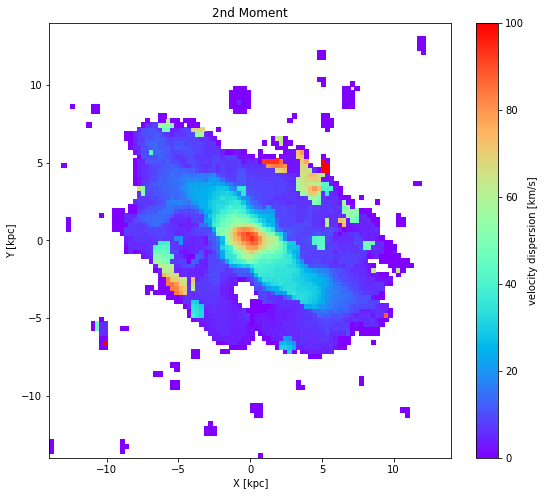

In [11]:
mrk79_mom2=np.sqrt(np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0)*(vv2[:,None,None]-mrk79_mom1)**2,axis=0)/(mrk79_mom0/np.abs(dv)))
plt.figure(figsize=(9,8))
plt.pcolormesh(xx_kpc,yy_kpc,mrk79_mom2,vmin=0,vmax=100, cmap='rainbow')
plt.colorbar(label='velocity dispersion [km/s]')
#plt.contour(xx_kpc,yy_kpc,mrk79_mom2,cmap='gray')
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]")
plt.title("2nd Moment")
plt.show()


### Inclination & Mass

In [12]:
from astropy import constants as const

GG=const.G.to('kpc3 / (kg s2)')
G=GG.value
vmax=np.nanmax(mrk79_mom1) #maximum rotational velocity corrected for inclination (HyperLeda)
vmax_kpc=(vmax*(u.km/u.s)).to(u.kpc/u.s)
a=(30.90)*ak #semi-major axis in kpc (2MASS)
b=(16.068)*ak
"""
a=(30.90)*ak #semi-major axis in kpc (2MASS)
da=0.33*ak
b=(16.068)*ak #semi-minor axis in kpc (2MASS)
db=0.33*ak
sini=np.sqrt(1-(b/a)**2) #inclination
dsini=(b/(a**2*sini))*np.sqrt((da*b/a)**2 + db**2)
di=np.rad2deg(np.arcsin(dsini))
"""
inc=33    
sini=np.sin(np.deg2rad(inc)) #<---This is the inclination
cosi=np.cos(np.deg2rad(inc))
print("the inclination is i =","{:.4}".format(np.rad2deg(np.arcsin(sini))))  #,"+-","{:.2}".format(di),"deg")

Mkg=(a*(vmax_kpc.value)**2)/G
Msun=Mkg/const.M_sun.value

print("Mass of mrk79 =","{:.2e}".format(Msun),"M_sun")

the inclination is i = 33.0
Mass of mrk79 = 3.91e+11 M_sun


### Calculate the a parameter of Hernquist from the maximum velocity 

 a0  =  3.5 kpc


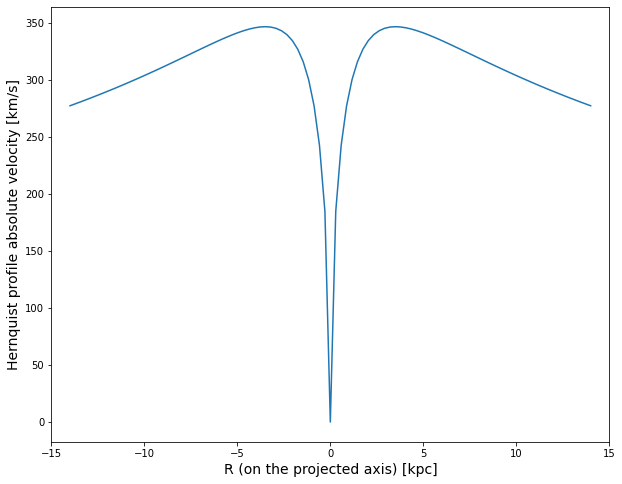

In [13]:
rr=yy_kpc
for a0 in enumerate(rr):
    vc=np.sqrt(G*Mkg*np.abs(rr))/(np.abs(rr)+np.abs(a0[1]))
    vc=((vc*(u.kpc/u.s)).to(u.km/u.s)).value
    if (vmax-4.7)<=np.max(vc) and np.max(vc)<=(vmax+4.7): 
        break
plt.figure(figsize=(10,8))
plt.plot(rr,vc)
plt.xlim(-15,15), plt.xlabel("R (on the projected axis) [kpc]",fontsize=14), plt.ylabel("Hernquist profile absolute velocity [km/s]",fontsize=14)
print(" a0  = ","{:.3}".format(np.abs(a0[1])),"kpc")


kms100=u.def_unit('kms100',100*u.km/u.s)
kms2100=u.def_unit('kms2100',(100*u.km/u.s)**2)
print(kms2100)
gg=const.G.to('(kpc kms2100/ (M_sun)')
gg


### Bertola model 

In [14]:
from scipy.optimize import curve_fit

def bertola(r,A,c,p):
    vc=A*r/((r**2+c**2)**(p/2))
    #vc=vc
    return vc
def bertfit1d(velo,rr,inparam):
    popt, pcov = curve_fit(bertola,rr,velo,p0=inparam, bounds=[[0,-2,1.3],[1000,10,1.5]])
    print('parameters of Bertola model: A=',"{:.5}".format(popt[0]),', c=',"{:.5}".format(popt[1]),', p=',"{:.5}".format(popt[2]))
    return popt

### Fitting of 1st Moment with the Hernquist profile

parameter a calculated from least squares fitting of Hernquist model: a= 9.7788119 kpc

parameters of Bertola model: A= 335.6 , c= 1.3424 , p= 1.4082


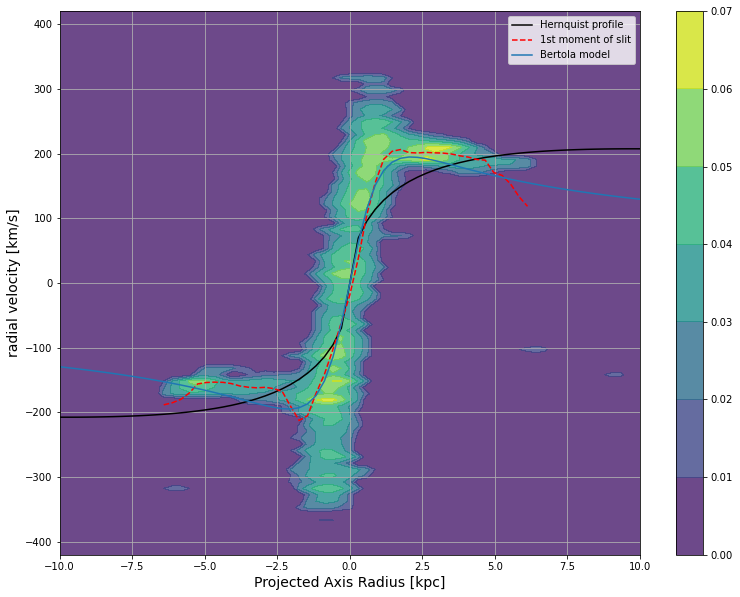

In [15]:

#Removing less than 5*sigma Intensities 
pvd_cubec=np.nansum(np.where(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)]>=5*sigma,rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],0),axis=2)

#if you don't want to remove low intensities just uncomment the line below 
#pvd_cubec=pvd_cube

mom0slit=np.nansum(pvd_cubec,axis=0)*np.abs(dv)
mom1slit=np.nansum(vv[:,None]*pvd_cubec,axis=0)/(mom0slit/np.abs(dv))

mom1slit=mom1slit/sini
def hern(r,a0): #Hernquist model velocity function
    vc=np.linspace(0,0,len(r))
    
    for n in range(len(r)):
        vc[n]=np.sqrt(G*Mkg*np.abs(r[n]))/(np.abs(r[n])+np.abs(a0))
        vc[n]=((vc[n]*(u.kpc/u.s)).to(u.km/u.s)).value
        if r[n]<0:
            vc[n]=-vc[n]
    return vc

pop,cov=curve_fit(hern, yy_kpc[26:70], mom1slit[26:70])
hern_model=hern(yy_kpc, pop[0])
plt.figure(figsize=(13,10))
plt.plot(yy_kpc,hern_model,'k',label='Hernquist profile')
plt.plot(yy_kpc[26:70],mom1slit[26:70],'r--',label='1st moment of slit')
plt.contourf(yy_kpc,vv/sini,pvd_cubec,alpha=0.8)
plt.colorbar()
plt.grid(), plt.xlim(-10,10), plt.ylim(-420,420), plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)

print('parameter a calculated from least squares fitting of Hernquist model: a=',"{:.8}".format(pop[0]),'kpc\n')

m2=mom1slit[26:70]
m2=np.where(np.isnan(m2),0,m2)
init_param=[200,2,1.5]
bertolaparam=bertfit1d(m2,yy_kpc[26:70],init_param)

plt.plot(yy_kpc,bertola(yy_kpc,bertolaparam[0],bertolaparam[1],bertolaparam[2]),label='Bertola model')
plt.legend()
plt.show()


### Rotation Curve from mean and maximum Intensities

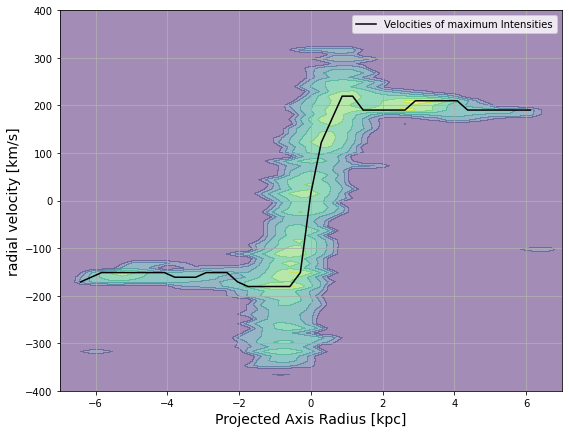

For maximum Intensities:

parameters of Bertola model: A= 265.45 , c= 0.69774 , p= 1.3
parameter a calculated from least squares fitting of Hernquist model: a = 9.2028534 kpc



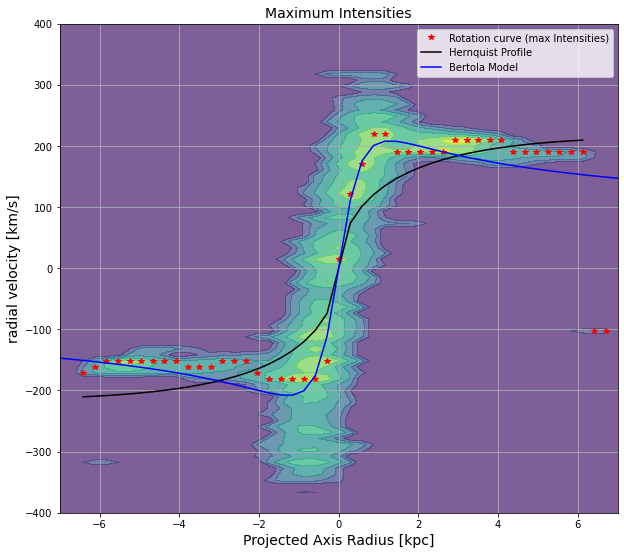

In [16]:
pvd_cubemax=np.linspace(0,0,mrk79_header['NAXIS1'])
vmaxslit=np.linspace(0,0,mrk79_header['NAXIS1'])
index=np.linspace(0,0,mrk79_header['NAXIS1'])
for k in range(mrk79_header['NAXIS1']):
    for m in range(mrk79_header['NAXIS3']):
        if pvd_cubemax[k]<=pvd_cubec[m,k]:
            pvd_cubemax[k]=pvd_cubec[m,k]
            index[k]=m
        vmaxslit[k]=vv[int(index[k])]   
vmaxslit=vmaxslit/sini
plt.figure(figsize=(9,7))
plt.contourf(yy_kpc,vv/sini,pvd_cubec,alpha=0.5)
x1=26;x2=70
plt.plot(yy_kpc[x1:x2],vmaxslit[x1:x2],'k',label='Velocities of maximum Intensities')
plt.legend()
plt.xlim(-7,7), plt.ylim(-400,400), plt.grid()
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.show()

print('\033[1m'+'For maximum Intensities:\n'+'\033[0m')

bert_paramax=bertfit1d(vmaxslit[x1:x2],yy_kpc[x1:x2],[200,4,1.5])

pop,cov=curve_fit(hern, yy_kpc[x1:x2], vmaxslit[x1:x2], p0=2,bounds=[0,25])
print('parameter a calculated from least squares fitting of Hernquist model: a =',"{:.8}".format(pop[0]),'kpc\n')
hern_model=hern(yy_kpc[x1:x2],pop)
plt.figure(figsize=(10,9))
plt.plot(yy_kpc,vmaxslit,'r*',label='Rotation curve (max Intensities)')
plt.plot(yy_kpc[x1:x2],hern_model,'k',label='Hernquist Profile')
plt.plot(yy_kpc,bertola(yy_kpc,bert_paramax[0],bert_paramax[1],bert_paramax[2]),'b', label='Bertola Model')
plt.legend()
plt.contourf(yy_kpc,vv/sini,pvd_cubec,alpha=0.7)
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.xlim(-7,7), plt.ylim(-400,400), plt.grid()
plt.title('Maximum Intensities', fontsize=14)

plt.show()

In [17]:
ydata=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1).ravel()
xy_mesh=np.meshgrid(xx_kpc,yy_kpc)

### Bertola Velocity Field

In [18]:
# This is the function used to do the fit
def velf_bert(xy_mesh,incl,pa): # xy_mesh is not used inside the function, it is just needed for the curve_fit function 
    A=bert_paramax[0]
    c=bert_paramax[1]
    p=bert_paramax[2]  
    pa=pa+180 #/2-90
    
    cosin=np.cos(np.deg2rad(incl))
    sinin=np.sin(np.deg2rad(incl))
    ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
    g=np.zeros(shape=(len(xx_kpc),len(yy_kpc)))
    tiny=0.0000001
    for i in range(len(xx_kpc)):
        for j in range(len(yy_kpc)):
            x=dx_kpc*(i-xcen)
            y=dx_kpc*(j-ycen)
            xpr = (x*cp+y*sp)/ci
            ypr = (-x*sp+y*cp)
            
            xr=np.sqrt(xpr**2+ypr**2)
            rr=np.sqrt(x**2+y**2)
            
            the=math.acos(y/(rr+tiny))
            if x<=0:
                the=the
            else:
                the=-the
            the=the+np.deg2rad(-pa)
            
            
            g[i,j]=(A*rr*np.cos(the)*si*ci**p)/(rr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)
    g=np.where(np.isnan(mrk79_mom1),0,g)
    return np.ravel(g)


In [19]:
def model_plot(x, y, moment, model,pa, vmin, vmax, resmin, resmax, contour='contourf',cmap='seismic', levels=120, option='model',res='Residuals'): #for plotting moment1, model & residuals
    if contour=='contourf':
        fig = plt.figure(figsize=(20,16))
        gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
        gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

        ax0 = fig.add_subplot(gs[1,0])
        cax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[1,1])
        cax1 = fig.add_subplot(gs[0,1])
        ax2=fig.add_subplot(gs[1,2])
        cax2=fig.add_subplot(gs[0,2])

        c0=ax0.contourf(x, y, moment,vmin=vmin,vmax=vmax,cmap=cmap,levels=np.linspace(vmin,vmax,levels))
        plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=10)
        ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
        ax0.plot(x,yslit_low(x,pa),'--',alpha=0.3, color='black')
        ax0.plot(x,yslit_high(x,pa),'--',alpha=0.3, color='black')
        ax0.set_xlim([np.min(x),np.max(x)])
        ax0.set_ylim([np.min(y),np.max(y)])

        c1=ax1.contourf(x,y,model,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,levels))
        plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=10)  
        ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title=option)   
        ax1.plot(x,yslit_low(x,pa),'--',alpha=0.3, color='black')
        ax1.plot(x,yslit_high(x,pa),'--',alpha=0.3, color='black')
        ax1.set_xlim([np.min(x),np.max(x)])
        ax1.set_ylim([np.min(y),np.max(y)])

        c2=ax2.contourf(x,y,moment-model,vmin=resmin,vmax=resmax ,cmap=cmap,levels=np.linspace(resmin,resmax,levels))
        plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=10)
        ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title=res)   
        ax2.plot(x,yslit_low(x,pa),'--',alpha=0.3, color='black')
        ax2.plot(x,yslit_high(x,pa),'--',alpha=0.3, color='black')
        ax2.set_xlim([np.min(x),np.max(x)])
        ax2.set_ylim([np.min(y),np.max(y)])
    elif contour=='pcolormesh':
        fig = plt.figure(figsize=(20,16))
        gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
        gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

        ax0 = fig.add_subplot(gs[1,0])
        cax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[1,1])
        cax1 = fig.add_subplot(gs[0,1])
        ax2=fig.add_subplot(gs[1,2])
        cax2=fig.add_subplot(gs[0,2])

        c0=ax0.pcolormesh(x,y,moment,vmin=vmin,vmax=vmax,cmap=cmap)
        plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=10)
        ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
        ax0.plot(x,yslit_low(x,pa),'--',alpha=0.3, color='black')
        ax0.plot(x,yslit_high(x,pa),'--',alpha=0.3, color='black')
        ax0.set_xlim([np.min(x),np.max(x)])
        ax0.set_ylim([np.min(y),np.max(y)])

        c1=ax1.pcolormesh(x,y,model,cmap=cmap,vmin=vmin,vmax=vmax)
        plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=10)  
        ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title=option)   
        ax1.plot(x,yslit_low(x,pa),'--',alpha=0.3, color='black')
        ax1.plot(x,yslit_high(x,pa),'--',alpha=0.3, color='black')
        ax1.set_xlim([np.min(x),np.max(x)])
        ax1.set_ylim([np.min(y),np.max(y)])

        c2=ax2.pcolormesh(x,y,moment-model,vmin=resmin,vmax=resmax ,cmap=cmap)
        plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=10)
        ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title=res)   
        ax2.plot(x,yslit_low(x,pa),'--',alpha=0.3, color='black')
        ax2.plot(x,yslit_high(x,pa),'--',alpha=0.3, color='black')
        ax2.set_xlim([np.min(x),np.max(x)])
        ax2.set_ylim([np.min(y),np.max(y)])
    return plt.show()

### Fit of 1st Moment

In [20]:
fit_init_params=[inc,papvds[1],bert_paramax[0],bert_paramax[1],bert_paramax[2]]  #inclination, PA
fit_init_params2=[inc,papvds[1]]
X,Y=np.meshgrid(xx_kpc,yy_kpc)
ydata=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1).ravel()
xy_mesh=np.meshgrid(xx_kpc,yy_kpc)
inc_pa,covar=curve_fit(velf_bert,xy_mesh,ydata,p0=fit_init_params2,sigma=np.linspace(np.abs(dv),np.abs(dv),len(ydata)),absolute_sigma=True,bounds=(0,[90,180]))


### Fit only inclination and PA

Fitted parameters:
inclination =  27.73  deg
PA =  129.49  deg


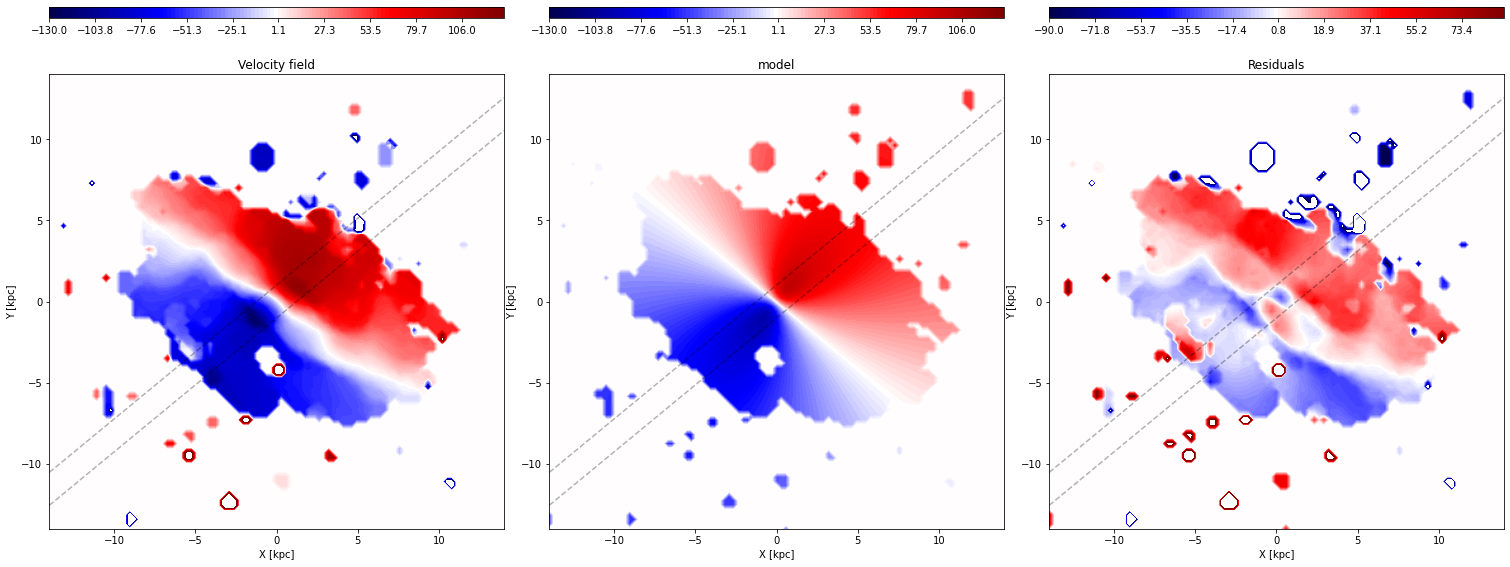

In [21]:
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':  ((0.0, 0.0, 0.0),
                 (1/6., 0.0, 0.0),
                 (1/2., 0.8, 1.0),
                 (5/6., 1.0, 1.0),
                 (1.0, 0.4, 1.0)),

             'blue':  ((0.0, 0.0, 0.4),
                 (1/6., 1.0, 1.0),
                 (1/2., 1.0, 0.8),
                 (5/6., 0.0, 0.0),
                 (1.0, 0.0, 0.0)),

             'green': ((0.0, 0.0, 0.0),
                 (1/6., 0.0, 0.0),
                 (1/2., 0.9, 0.9),
                 (5/6., 0.0, 0.0),
                 (1.0, 0.0, 0.0))

        }

custom_map=LinearSegmentedColormap('rg',cdict, N=256)

print("Fitted parameters:\ninclination = ","{:.4}".format(inc_pa[0])," deg\nPA = ","{:.5}".format(inc_pa[1])," deg")
vf_fit=velf_bert(xy_mesh,inc_pa[0],inc_pa[1])

model_plot(xx_kpc, yy_kpc, ydata.reshape(len(xx),len(yy)), vf_fit.reshape(len(xx),len(yy)),inc_pa[1], -130, 130, -90, 90,contour='contourf',cmap='seismic')


### Fit of A,c,p and inc,PA

In [22]:
def velf_bert2(xy_mesh, incl,pa,A,c,p): # xy_mesh is not used inside the function, it is just needed for the curve_fit function       
    #pa=inc_pa[1]+180;
    #incl=inc_pa[0]#incl=90-incl
    pa=pa+180
    cosin=np.cos(np.deg2rad(incl))
    sinin=np.sin(np.deg2rad(incl))
    ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
    g=np.zeros(shape=(len(xx_kpc),len(yy_kpc)))
    tiny=0.000000000001
    for i in range(len(xx_kpc)):
        for j in range(len(yy_kpc)):
            x=dx_kpc*(i-xcen)
            y=dx_kpc*(j-ycen)
            
            r=np.sqrt(x**2+y**2)
            the=math.acos(y/(r+tiny))
            
            if x<0:
                the=+the
            else:
                the=-the
            the=the+np.deg2rad(-pa)
            
            g[i,j]=(A*r*np.cos(the)*si*ci**p)/(r**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)
    g=np.where(np.isnan(mrk79_mom1),0,g)
    return np.ravel(g)

fit_init_params2=[ 30.12,145,245.97, 13.2, 1.5]#[inc_pa[0],inc_pa[1],bert_param[0],bert_param[1],bert_param[2]]  #inclination, PA
par,cov=curve_fit(velf_bert2,xy_mesh,ydata,p0=fit_init_params2,sigma=np.linspace(np.abs(dv),np.abs(dv),len(ydata)),bounds=([0.12,0,0,0.0,1],[90.13,180,360,25,1.5]))


Fitted parameters:
inclination =  28.5  deg
PA =  129.93  
A =  360.0 
c =  0.89347 
p =  1.5


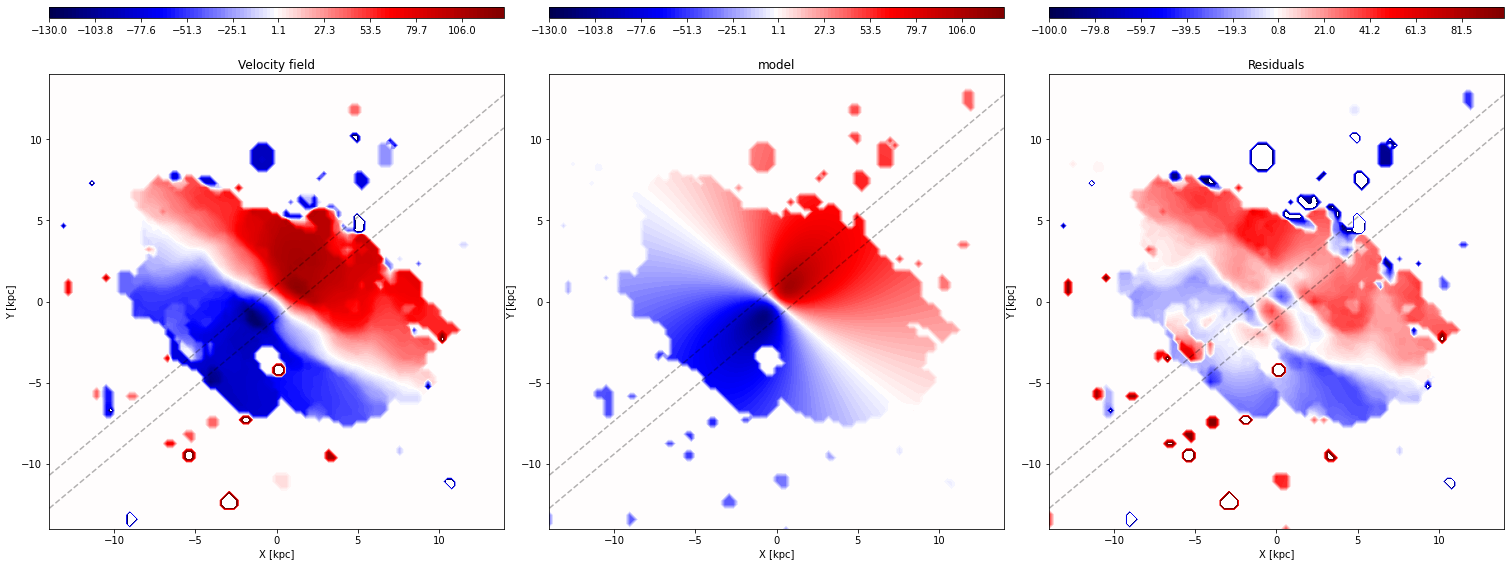

In [23]:
vf_fit2=velf_bert2(xy_mesh,par[0],par[1],par[2],par[3],par[4])
print("Fitted parameters:\ninclination = ","{:.4}".format(par[0])," deg\nPA = ","{:.5}".format(par[1]),
      " \nA = ","{:.5}".format(par[2]),"\nc = ","{:.5}".format(par[3]),"\np = ","{:.5}".format(par[4]))

model_plot(xx_kpc, yy_kpc, ydata.reshape(len(xx),len(yy)), vf_fit2.reshape(len(xx),len(yy)),par[1], -130, 130, -100, 100,contour='contourf')


### Tilted Ring Method

In [24]:
# dr=slit/2#<--ring width
# par_rings=np.array([])
# num_of_rings=20
# #global ipix
# #r_thick=np.linspace(slit/4,0.2*num_of_rings*slit/4,num_of_rings) #ring width increases
# for l in range(num_of_rings):

#     def bert_rings(xy_mesh,incl,pa):  #This is used for the fit
#         A=par[2]
#         c=par[3]
#         p=par[4]
#         pa=pa+180 #/2+90
#         #ip=np.array([])
#         #jp=np.array([])
#         g=[]
#         cosin=np.cos(np.deg2rad(incl))
#         sinin=np.sin(np.deg2rad(incl))
#         ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
        
#         tiny=0.000000001
#         np_ring=0
#         for i in range(len(xx_kpc)):
#             for j in range(len(yy_kpc)):
                
#                 x=dx_kpc*(i-xcen)
#                 y=dx_kpc*(j-ycen)
#                 xpr = (x*cp+y*sp)/ci
#                 ypr = (-x*sp+y*cp)
#                 ipr=int(xpr/dx_kpc+xcen)
#                 jpr=int(ypr/dx_kpc+ycen)
#                 rr=np.sqrt(x**2+y**2)
#                 xr=np.sqrt(xpr**2+ypr**2)
#                 if xr<=(l+1)*dr and xr>=l*dr:
#                     #ip=np.append(ip,i)
#                     #jp=np.append(jp,j)
#                     the=math.acos(ypr/((xr)+tiny))

#                     if xpr<=0:
#                         the=the
#                     else:
#                         the=-the
#                     the=the+np.deg2rad(-pa)
#                     if np.isnan(mrk79_mom1[ipr,jpr]):
#                         g=np.append(g,0)
#                     else:
#                         g=np.append(g,(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2))                  
#                     np_ring+=1        
        
#         #ipix= np.empty(shape=(2,len(ip)),dtype='object')
       
#         #ipix[0]=ip
#         #ipix[1]=jp
#         return g
    
#     def moment1_rings(incl=par[0], pa=par[1]): #Gets the moment1 map values for each ring
#         ring_m1=np.array([])
#         pa=pa/2+90

#         cosin=np.cos(np.deg2rad(incl))
#         sinin=np.sin(np.deg2rad(incl))
#         ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
#         tiny=0.000000001
        
# #         ip=ipix
# #         jp=ipix
# #         for n in range(len(ip)):
# #             ring_m1=np.append(ring_m1, mrk79_mom1[int(ip[n]),int(jp[n])])
#         for i in range(len(xx_kpc)):
#             for j in range(len(yy_kpc)):
#                 x=dx_kpc*(i-xcen)
#                 y=dx_kpc*(j-ycen)
#                 rr=np.sqrt(x**2+y**2)

#                 xpr = (x*cp+y*sp)/ci
#                 ypr = (-x*sp+y*cp)
#                 xr=np.sqrt(xpr**2+ypr**2)

#                 ipr=math.floor(xpr/dx_kpc+xcen)
#                 jpr=math.floor(ypr/dx_kpc+ycen)
#                 if xr<=(l+1)*dr and xr>=l*dr:

#                     if ipr>=97 or jpr>=97:
#                         ring_m1=np.append(ring_m1,0)
#                     else:    
#                         ring_m1=np.append(ring_m1, mrk79_mom1[ipr,jpr])
                
# #         pa=135
# #         incl=35
# #         pa=pa/2+90
# #         cosin=np.cos(np.deg2rad(incl))
# #         sinin=np.sin(np.deg2rad(incl))
# #         ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
# #         tiny=0.000000001
# #         for i in range (len(xx)):
# #             for j in range(len(yy)):
# #                 x=dx_kpc*(i-xcen)
# #                 y=dx_kpc*(j-ycen)
# #                 radius=np.sqrt(x**2+y**2)
# #                 xpr = (x*cp+y*sp)/ci
# #                 ypr = (-x*sp+y*cp)
# #                 xr=np.sqrt(xpr**2+ypr**2)
# #                 if radius<=(l+1)*dr and radius>=l*dr:
# #                     ring_m1=np.append(ring_m1,mrk79_mom1[i,j])
#         return np.where(np.isnan(ring_m1),0,ring_m1)
    
#     par_ring=curve_fit(bert_rings,xy_mesh,moment1_rings(par[0],par[1]),p0=[par[0],par[1]],sigma=np.linspace(np.abs(dv),np.abs(dv),len(moment1_rings())),absolute_sigma=True,bounds=([10,100],[50,180]))
#     par_rings=np.append(par_rings,par_ring[0])

In [25]:
# print(num_of_rings)
# def ring_vf(incl,pa,nring): #Creates a velocity field for every ring, where outside the rings the values are 0
#     A=par[2]
#     c=par[3]
#     p=par[4]
#     pa=pa/2+90

#     xcen=ycen=48
#     g=np.zeros(shape=(len(xx), len(yy)))
#     cosin=np.cos(np.deg2rad(incl))
#     sinin=np.sin(np.deg2rad(incl))
#     ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))

#     tiny=0.000000001
#     np_ring=0
#     for i in range(len(xx_kpc)):
#         for j in range(len(yy_kpc)):
#             x=dx_kpc*(i-xcen)
#             y=dx_kpc*(j-ycen)
#             xpr = (x*cp+y*sp)/ci
#             ypr = (-x*sp+y*cp)
#             ipr=int(xpr/dx_kpc+xcen)
#             jpr=int(ypr/dx_kpc+ycen)
#             rr=np.sqrt(x**2+y**2)
#             xr=np.sqrt(xpr**2+ypr**2)
#             if rr<=(nring+1)*dr and rr>=nring*dr:
#                 the=math.acos(ypr/(np.max(xr)+tiny))

#                 if xpr<=0:
#                     the=the
#                 else:
#                     the=-the
#                 the=the+np.deg2rad(-pa)
#                 if ipr>=97 or jpr>=97: break
#                 if np.isnan(mrk79_mom1[i,j]):
#                     g[i,j]=0
#                 else:
#                     g[i,j]=(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)                 
#                 np_ring+=1   
#     return g
# model_image=np.zeros(shape=(len(xx),len(yy)))
# for l in range(num_of_rings): 
#     #dr=r_thick[l]
#     model_image=model_image+ring_vf(par_rings[2*l],par_rings[2*l+1],l) #Adding all the ring velocity fields

# fig = plt.figure(figsize=(20,16))
# gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
# gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

# ax0 = fig.add_subplot(gs[1,0])
# cax0 = fig.add_subplot(gs[0,0])
# ax1 = fig.add_subplot(gs[1,1])
# cax1 = fig.add_subplot(gs[0,1])
# ax2=fig.add_subplot(gs[1,2])
# cax2=fig.add_subplot(gs[0,2])

# c0=ax0.contourf(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=120,levels=np.linspace(-120,120,100),cmap='seismic')
# plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=11)
# ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
# ax0.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax0.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
# ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

# c1=ax1.contourf(xx_kpc,yy_kpc,model_image,cmap='seismic',vmin=-120,vmax=120,levels=np.linspace(-120,120,100))
# plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=11)  
# ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
# ax1.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax1.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
# ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

# c2=ax2.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy))-model_image,alpha=1,vmin=-50,vmax=50 ,cmap='seismic',levels=np.linspace(-50,50,100))
# plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=11)
# ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
# ax2.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax2.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
# ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
# print("Fit only Inclination and PA")
# plt.show()
# print(dr)
# for l in range(0,num_of_rings,1):
#     print('ring',l,'\tMiddle Radius:',(2*l+1)*dr/2, '\tinclination:', "{:.4e}".format(par_rings[2*l]), '\tPA:', "{:.4e}".format(par_rings[2*l+1]))


In [26]:
# dr=slit/2 #<--ring width
# par_rings=np.array([])
# num_of_rings=25
# #r_thick=np.linspace(slit/4,0.2*num_of_rings*slit/4,num_of_rings)
# for l in range(num_of_rings):
#     #dr=r_thick[l]
    
#     def bert_rings(xy_mesh,incl,pa,A,c,p):  #This is used for the fit
        
        
#         xcen=ycen=48
#         g=[]
#         cosin=np.cos(np.deg2rad(incl))
#         sinin=np.sin(np.deg2rad(incl))
#         ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
        
#         tiny=0.001
#         np_ring=0
#         for i in range(len(xx_kpc)):
#             for j in range(len(yy_kpc)):
#                 x=dx_kpc*(i-xcen)*ci
#                 y=dx_kpc*(j-ycen)
#                 xpr=(-x*sp+y*cp)#/ci
#                 ypr=(-x*cp-y*sp)#/ci
#                 rr=np.sqrt(x**2+y**2)
#                 xr=np.sqrt(xpr**2+ypr**2)
#                 if rr<=(l+1)*dr and rr>=l*dr:
#                     the=math.acos(ypr/((xr)+tiny))

#                     if xpr<=0:
#                         the=the
#                     else:
#                         the=-the
#                     the=the+np.deg2rad(-pa)
#                     if np.isnan(mrk79_mom1[i,j]):
#                         g=np.append(g,0)
#                     else:
#                         g=np.append(g,(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2))                  
#                     np_ring+=1        
#         return g
    
#     def moment1_rings(): #Gets the moment1 map values for each ring
#         ring_m1=np.array([])
#         xcen=ycen=48

#         for i in range (len(xx)):
#             for j in range(len(yy)):
#                 x=dx_kpc*(i-xcen)
#                 y=dx_kpc*(j-ycen)
#                 radius=np.sqrt(x**2+y**2)
#                 if radius<=(l+1)*dr and radius>=l*dr:
#                     ring_m1=np.append(ring_m1,mrk79_mom1[i,j])
#         return np.where(np.isnan(ring_m1),0,ring_m1)
#     #p0=[inc_pa[0],par[1],par[2],par[3],par[4]]
#     par_ring=curve_fit(bert_rings,xy_mesh,moment1_rings(), p0=[inc_pa[0],par[1],par[2],par[3],par[4]],bounds=([10,100,0,-2,1],[65,160,5000,5,1.5]))
#     par_rings=np.append(par_rings,par_ring[0])

In [27]:
# def ring_vf(incl,pa,A,c,p,nring): #Creates a velocity field for every ring, where outside the rings the values are 0
    
#     xcen=ycen=48
#     g=np.zeros(shape=(len(xx), len(yy)))
#     cosin=np.cos(np.deg2rad(incl))
#     sinin=np.sin(np.deg2rad(incl))
#     ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))

#     tiny=0.001
#     np_ring=0
#     for i in range(len(xx_kpc)):
#         for j in range(len(yy_kpc)):
#             x=dx_kpc*(i-xcen)
#             y=dx_kpc*(j-ycen)
#             xpr=(-x*sp+y*cp)
#             ypr=(-x*cp-y*sp)/ci
#             rr=np.sqrt(x**2+y**2)
#             xr=np.sqrt(xpr**2+ypr**2)
#             if rr<=(nring+1)*dr and rr>=nring*dr:
#                 the=math.acos(ypr/(xr+tiny))

#                 if xpr<=0:
#                     the=the
#                 else:
#                     the=-the
#                 the=the+np.deg2rad(-pa)
#                 if np.isnan(mrk79_mom1[i,j]):
#                     g[i,j]=0
#                 else:
#                     g[i,j]=(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)                 
#                 np_ring+=1   
#     #g=np.where(np.isnan(mrk79_mom1),0,g)
#     return g
# model_image=np.zeros(shape=(len(xx),len(yy)))
# for l in range(num_of_rings): 
#     #dr=r_thick[l]
#     model_image=model_image+ring_vf(par_rings[5*l],par_rings[5*l+1],par_rings[5*l+2],par_rings[5*l+3],par_rings[5*l+4],l) #Adding all the ring velocity fields

# fig = plt.figure(figsize=(20,16))
# gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
# gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

# ax0 = fig.add_subplot(gs[1,0])
# cax0 = fig.add_subplot(gs[0,0])
# ax1 = fig.add_subplot(gs[1,1])
# cax1 = fig.add_subplot(gs[0,1])
# ax2=fig.add_subplot(gs[1,2])
# cax2=fig.add_subplot(gs[0,2])

# c0=ax0.contourf(xx_kpc,yy_kpc,mrk79_mom1,vmin=-130,vmax=130,levels=np.linspace(-130,130,120),cmap='seismic')
# plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=11)
# ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
# ax0.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax0.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
# ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

# c1=ax1.contourf(xx_kpc,yy_kpc,model_image,cmap='seismic',vmin=-130,vmax=130,levels=np.linspace(-130,130,120))
# plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=11)  
# ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
# ax1.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax1.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
# ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

# c2=ax2.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy))-model_image,vmin=-60,vmax=60 ,cmap='seismic',levels=np.linspace(-60,60,120))
# plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=11)
# ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
# ax2.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax2.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
# ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
# ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
# print("Fit all parameters")
# plt.show()
# np.nanmax(mrk79_mom1)
# for l in range(0,num_of_rings,1):
#     print('ring',l,'\tMiddle of ring:',(2*l+1)*dr/2, '\tinclination:', "{:.4e}".format(par_rings[5*l]), '\tPA:', "{:.4e}".format(par_rings[5*l+1]))


### Optical Image & CO(1-0) moment 0

In [28]:
opticalfits=["g.fits","r.fits","i.fits","z.fits"]
datafolder_opt='/home/apostolis/Desktop/mrk79/mrk79_1d_2d/optical/'
g_fits=fits.open(datafolder_opt+opticalfits[0])
r_fits=fits.open(datafolder_opt+opticalfits[1])
i_fits=fits.open(datafolder_opt+opticalfits[2])
z_fits=fits.open(datafolder_opt+opticalfits[3])

#fits.HDUList.info(r_fits)

gheader=g_fits[0].header
rheader=r_fits[0].header
iheader=i_fits[0].header
zheader=z_fits[0].header

gdata=g_fits[0].data
rdata=r_fits[0].data
idata=i_fits[0].data
zdata=z_fits[0].data

g_fits.close()
r_fits.close()
i_fits.close()
z_fits.close()

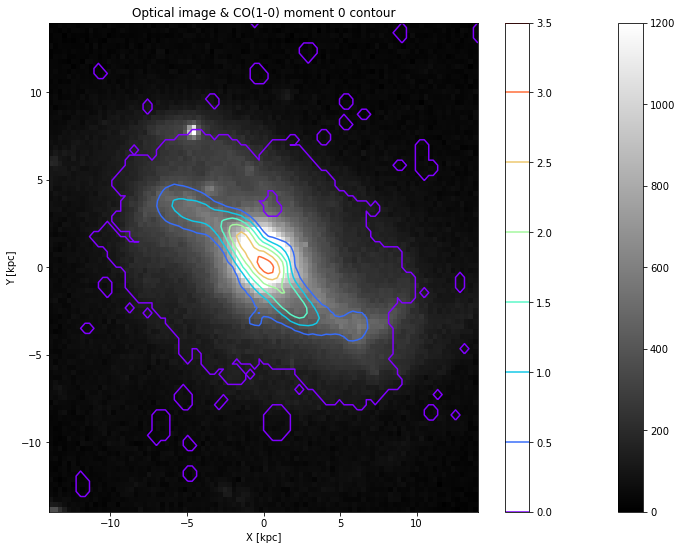

In [29]:
final_image=gdata+rdata+idata+zdata
plt.figure(figsize=(12,9))
center=[np.int(rheader["CRPIX1"]),np.int(rheader["CRPIX1"])]
final_image2=final_image[center[0]-48:center[0]+48, center[0]-48:center[0]+48]

plt.pcolormesh(xx_kpc,yy_kpc,final_image2,cmap='gray',vmin=0,vmax=1200), plt.colorbar()
plt.contour(xx_kpc,yy_kpc,np.rot90(mrk79_mom0,k=2,axes=(0,1)),cmap='rainbow'), plt.colorbar()
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]"), plt.title("Optical image & CO(1-0) moment 0 contour")
display()

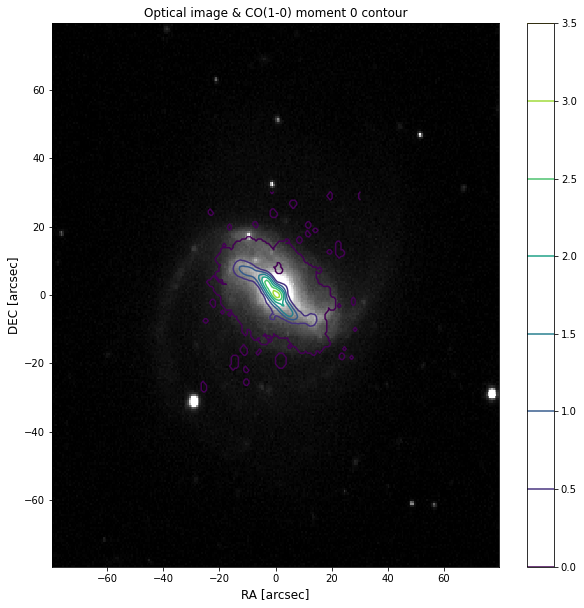

In [30]:
plt.figure(figsize=(10,10))
xx1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak #arcsec
yy1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak 
plt.pcolormesh(xx1,yy1,final_image,cmap='gray',vmin=0,vmax=800)
plt.contour(xx,yy,np.rot90(mrk79_mom0,k=-2,axes=(0,1))), plt.colorbar()
plt.xlabel("RA [arcsec]",fontsize=12), plt.ylabel("DEC [arcsec]",fontsize=12), plt.title("Optical image & CO(1-0) moment 0 contour")
plt.savefig('mrk79_opt.png', dpi=300, bbox_inches='tight')
display()

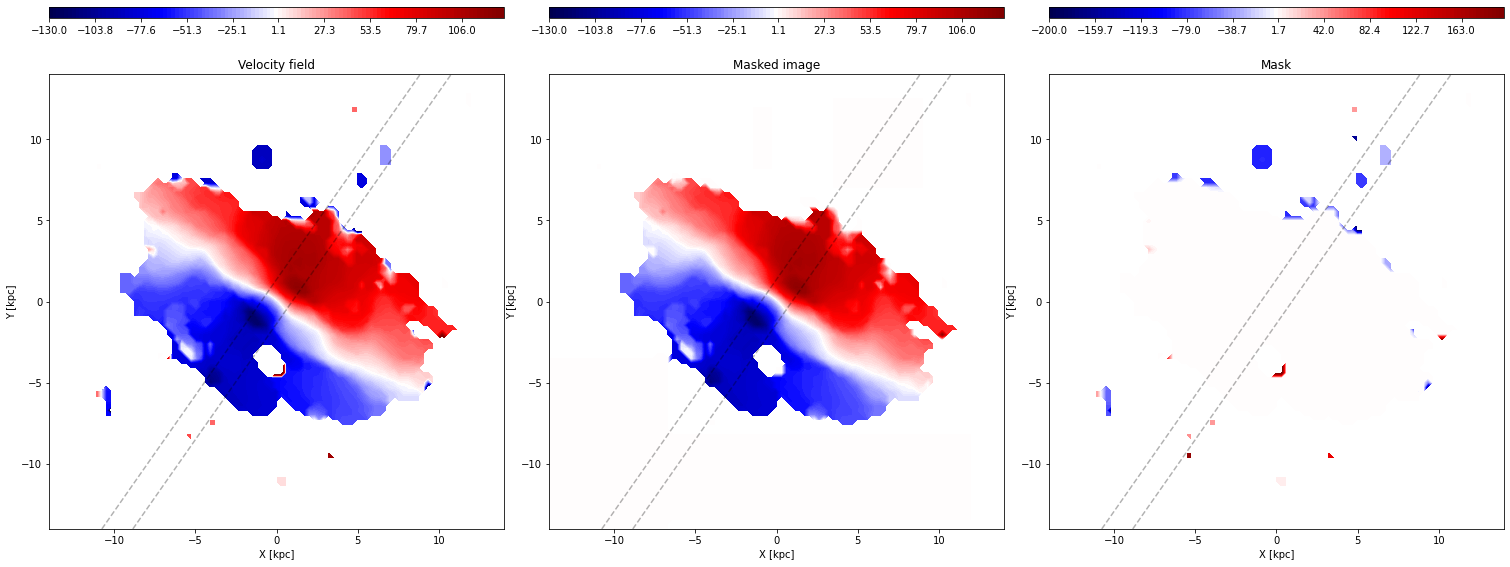

In [32]:
import matplotlib.patches as patches
masked=np.nan*np.ones(shape=(len(xx),len(yy)))
x_mask1=np.arange(76,90); x_mask2=np.arange(72,92); x_mask3=np.arange(2,21); x_mask4=np.arange(0,37)
y_mask1=np.arange(43,48); y_mask2=np.arange(60,80); y_mask3=np.arange(10,90); y_mask4=np.arange(0,26)
masked[:,:]=mrk79_mom1[:,:]
def mask_moment1(x_mask,y_mask,image=masked):
    masked[:,:]=image[:,:]
    for ix in x_mask:
        for iy in y_mask:
            masked[ix,iy]=0
    return masked
masked = mask_moment1(x_mask1,y_mask1)
masked=mask_moment1(x_mask2, y_mask2, masked)
masked=mask_moment1(x_mask3, y_mask3, masked)
masked=mask_moment1(x_mask4, y_mask4, masked)
masked=np.where(abs(masked)>=130,0,masked)
for i in range(masked.shape[0]):
    for j in range(masked.shape[1]):
        if yy_kpc[j]>np.tan(np.radians(127))*(xx_kpc[i])+4*dx_kpc:
            if masked[i,j]<0:
                masked[i,j]=0
        if yy_kpc[j]<np.tan(np.radians(127))*(xx_kpc[i])-4*dx_kpc:
            if masked[i,j]>0:
                masked[i,j]=0
model_plot(xx_kpc, yy_kpc,mrk79_mom1, masked, vmin=-130, vmax=130, resmin=-200, resmax=200,pa=papvds[1], option='Masked image', res='Mask')


In [33]:
#masked=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1)
pixco = theta_all = R_all = vel_all = np.array([])
incl=30; pa=130; A=245.98; c=1.2; p=1.5; 
#pa=pa#-180
ci=np.cos(np.deg2rad(incl)); si=np.sin(np.deg2rad(incl)); cp=np.cos(np.deg2rad(pa+180)); sp=np.sin(np.deg2rad(pa+180))
#mom1nan= np.where(np.isnan(masked), 0, masked)
global tiny; tiny=np.finfo(float).eps
for i in range(len(xx)):
    for j in range(len(yy)):
        ix=i-xcen; iy=j-ycen
        x=ix*dx_kpc; y=iy*dx_kpc
        r=np.sqrt(x**2+y**2)
            
        xpr = (x*cp+y*sp)/ci
        ypr = (-x*sp+y*cp)
        xr=np.sqrt(xpr**2+ypr**2)
            
        ipr= math.floor((ix*cp+iy*sp)/ci)+xcen
        jpr= math.floor((-ix*sp+iy*cp))+ycen
        if ipr>=97 or jpr>=97: continue
        if xpr<=0:
            theta_all=np.append(theta_all, math.acos(ypr/ (xr + tiny)))
        else:
            theta_all=np.append(theta_all,-math.acos(ypr/ (xr + tiny)))
        pixco=np.append(pixco,(i,j))
        R_all=np.append(R_all,xr)
        vel_all=np.append(vel_all, masked[i,j])

In [34]:
def fit_func(R, theta, moment1,incl,pa, A, c, p):
    R_theta=[R, theta]
    def ring_model(R_theta, incl, pa):#, A, c, p):  
        pa=pa+180

        g=np.array([])
        ci=np.cos(np.deg2rad(incl)); si=np.sin(np.deg2rad(incl)); cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))

        R= R_theta[0]; the=R_theta[1]
        for i, r in enumerate(R):
            th = the[i]+np.deg2rad(-pa)
            g =np.append(g,(A*r*np.cos(th)*si*ci**p)/(r**2*(np.sin(th)**2+ci**2*np.cos(th)**2)+c**2*ci**2)**(p/2))
        
        return g
    
    parameters, cov= curve_fit(ring_model, R_theta, moment1 , p0=[incl, pa],# xc, yc], 
                              bounds=([5, -180],[70, 180]))
    
    return parameters 

def veloplot_ring(R, theta, incl, pa, A, c, p):#, xc, yc): #for plotting the fitted model
    pa=pa+180
    g=np.array([]) 
    ci=np.cos(np.deg2rad(incl)); si=np.sin(np.deg2rad(incl)); cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
    for i, r in enumerate(R):
        th=theta[i]+np.deg2rad(-pa)
        g=np.append(g,(A*r*np.cos(th)*si*ci**p)/(r**2*(np.sin(th)**2+ci**2*np.cos(th)**2)+c**2*ci**2)**(p/2))
    

    return g

In [35]:
R_thick=1*slit
R_ring = np.arange(R_thick,int(np.max(R_all)),R_thick)
initial=[incl, pa, A, c, p]
forplot=np.array([])
model=np.array([]); coordi=np.array([]); velim=np.array([]) 
parameters=np.zeros(shape=(2,len(R_ring)))
for ir, rings in enumerate(R_ring):
    
    i= -1
    ipix = np.array([]); R = np.array([]);  theta = np.array([]); image = np.array([]);
    print ("----------------------------------------------------------------")
    print ('\033[1m'+ "      Middle Radius of Ring",ir,"=", rings,' kpc'+'\033[0m')
    print ("----------------------------------------------------------------\n")
    for radi in R_all:
        i=i+1

        if abs(radi) <= 0.5*R_thick and rings==R_ring[0]:
            if np.isnan(vel_all[i])==False:
                ipix=np.append(ipix,i)
                R=np.append(R,R_all[i])
                theta=np.append(theta, theta_all[i])
                image=np.append(image, vel_all[i])
            
        if rings - 0.5*R_thick <  abs(radi) <= rings +0.5*R_thick:# and rings!=R_ring[0]:
            if np.isnan(vel_all[i])==False:    
                ipix=np.append(ipix,i)
                R=np.append(R,R_all[i])
                theta=np.append(theta, theta_all[i])
                image=np.append(image, vel_all[i])
        
    par=fit_func(R, theta, image, *initial)
    parameters[:,ir]=par
    model_ring = veloplot_ring( R, theta, *par, A, c, p)
    model = np.append(model, model_ring )
    coordi = np.append(coordi, ipix)
    velim = np.append(velim, image)
    
    print ('\033[1m'+ "i="+'\033[0m', "{:.4}".format(par[0]),'\033[1m'+"\tPA="+'\033[0m', "{:.4}".format(par[1]))#,'\033[1m'+"\tA="+'\033[0m', 
           #"{:.4}".format(par[2]),'\033[1m'+"\tc="+'\033[0m', "{:.4}".format(par[3]),'\033[1m'+"\tp="+'\033[0m', "{:.4}".format(par[4]))



----------------------------------------------------------------
      Middle Radius of Ring 0 = 1.5630979089019734  kpc
----------------------------------------------------------------

i= 50.92 	PA= 180.0
----------------------------------------------------------------
      Middle Radius of Ring 1 = 3.126195817803947  kpc
----------------------------------------------------------------

i= 48.93 	PA= 179.5
----------------------------------------------------------------
      Middle Radius of Ring 2 = 4.6892937267059205  kpc
----------------------------------------------------------------

i= 47.81 	PA= 177.0
----------------------------------------------------------------
      Middle Radius of Ring 3 = 6.252391635607894  kpc
----------------------------------------------------------------

i= 45.02 	PA= 176.8
----------------------------------------------------------------
      Middle Radius of Ring 4 = 7.815489544509867  kpc
------------------------------------------------------

ValueError: `ydata` must not be empty!

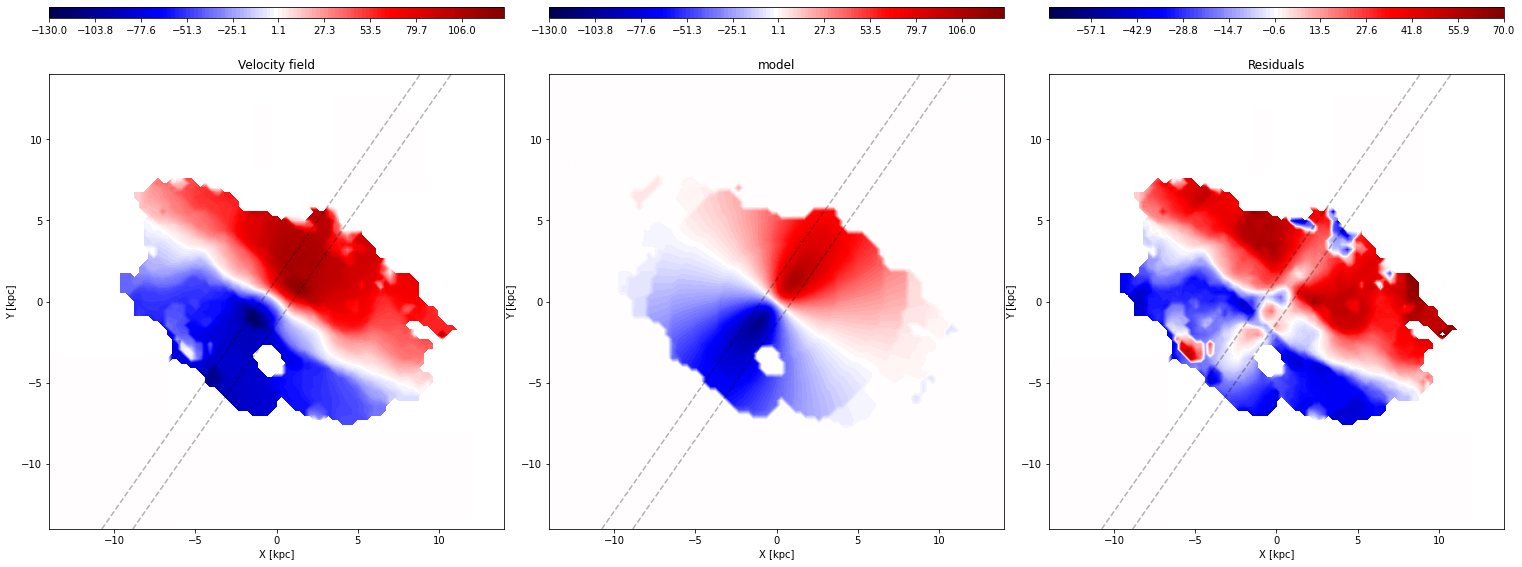

In [36]:
nx=97# int(np.sqrt(len(R_all)))+7
ny=nx
img_mod=np.nan * np.ones(shape=(nx,nx))
img_vel=np.nan * np.zeros(shape=(nx,nx))
img_res=np.nan * np.ones(shape=(nx,nx))

for ip, pix in enumerate(coordi):
    ipr=int(pixco[int(2*pix)])
    jpr=int(pixco[int(2*pix+1)])
    if ipr>=img_mod.shape[0] or jpr>=img_mod.shape[1]: break
    img_mod[ipr,jpr]=model[ip]
    img_vel[ipr,jpr]=velim[ip]
    img_res[ipr,jpr]=img_vel[ipr,jpr]-img_mod[ipr,jpr]
img_mod=np.where(img_vel==0,0,img_mod)

img_mod=np.where(np.isnan(mrk79_mom1),0,img_mod)
#model_cl=np.where(np.isnan(mrk79_mom1),0,model)
#img_vel=np.where(img_mod==0,0,img_vel)

x=xx_kpc[int(xcen - nx/2 ): int(xcen + nx/2)]
y=yy_kpc[int(ycen - ny/2 ): int(ycen + ny/2)]

model_plot(xx_kpc, yy_kpc, img_vel, img_mod, vmin=-130, vmax=130, resmin=-70, resmax=70,pa=145 ,contour='contourf', cmap='seismic')

In [37]:
mean=np.zeros(shape=(1,2))
for l in range(mean.shape[1]):
    mean[0][l]=np.nanmean(parameters[l,0:11])
mean
print('Mean values of parameters:','\n\nIncl:', mean[0][0], 'pa:',mean[0][1])#,'A:',mean[0][2],'c:',mean[0][3],'p:', mean[0][4])

Mean values of parameters: 

Incl: 23.736594906051938 pa: 151.08552756256134


In [38]:
pixco = theta_all = R_all = vel_all = np.array([])
incl=34; pa=95; A=100.98; c=0.68; p=1.4; 
#pa=pa-180
ci=np.cos(np.deg2rad(incl)); si=np.sin(np.deg2rad(incl)); cp=np.cos(np.deg2rad(pa+180)); sp=np.sin(np.deg2rad(pa+180))
#mom1nan= np.where(np.isnan(masked), 0, masked)
global tiny; tiny=np.finfo(float).eps
for i in range(len(xx)):
    for j in range(len(yy)):
        ix=i-xcen; iy=j-ycen
        x=ix*dx_kpc; y=iy*dx_kpc
        r=np.sqrt(x**2+y**2)
            
        xpr = (x*cp+y*sp)/ci
        ypr = (-x*sp+y*cp)
        xr=np.sqrt(xpr**2+ypr**2)
            
        ipr= math.floor((ix*cp+iy*sp)/ci)+xcen
        jpr= math.floor((-ix*sp+iy*cp))+ycen
        if ipr>=97 or jpr>=97: continue
        if xpr<=0:
            theta_all=np.append(theta_all, math.acos(ypr/ (xr + tiny)))
        else:
            theta_all=np.append(theta_all,-math.acos(ypr/ (xr + tiny)))
        pixco=np.append(pixco,(i,j))
        R_all=np.append(R_all,xr)
        vel_all=np.append(vel_all, masked[i,j])

In [60]:
def fit_func(R, theta, moment1, incl, pa, A, c, p):
    R_theta=[R, theta];
    #pa=pa+180
    
    def ring_model(R_theta, incl, pa, A, c, p):  
        #pa=pa+180

        g=np.array([])
        ci=np.cos(np.deg2rad(incl)); si=np.sin(np.deg2rad(incl)); cp=np.cos(np.deg2rad(180-pa)); sp=np.sin(np.deg2rad(180-pa))

        R= R_theta[0]; the=R_theta[1]
        for i, r in enumerate(R):
            th = the[i]-np.deg2rad(180-pa)
            g =np.append(g,(A*r*np.cos(th)*si*ci**p)/(r**2*(np.sin(th)**2+ci**2*np.cos(th)**2)+c**2*ci**2)**(p/2))
        
        return g
    
    parameters, cov= curve_fit(ring_model, R_theta, moment1 , p0=[incl, pa, A, c, p],# xc, yc], 
                              bounds=([0,0,0,0,1],[90,360,300,20,1.5]))
    
    return parameters 

def veloplot_ring(R, theta, incl, pa, A, c, p):#, xc, yc): #for plotting the fitted model
    #pa=pa+180
    g=np.array([]) 
    ci=np.cos(np.deg2rad(incl)); si=np.sin(np.deg2rad(incl)); cp=np.cos(np.deg2rad(180-pa)); sp=np.sin(np.deg2rad(180-pa))
    for i, r in enumerate(R):
        th=theta[i]-np.deg2rad(180-pa)
        g=np.append(g,(A*r*np.cos(th)*si*ci**p)/(r**2*(np.sin(th)**2+ci**2*np.cos(th)**2)+c**2*ci**2)**(p/2))
    

    return g

In [66]:
R_thick=slit/4 #slit/4 #1*slit/2
R_ring = np.arange(R_thick,int(np.sqrt(np.nanmax(xx_kpc)**2+np.nanmax(yy_kpc)**2)),R_thick)
initial=[incl, pa, A, c, p]
forplot=np.array([])
model=np.array([]); coordi=np.array([]); velim=np.array([]) 
parameters=np.zeros(shape=(5,len(R_ring)))
for ir, rings in enumerate(R_ring):
    
    i= -1
    ipix = np.array([]); R = np.array([]);  theta = np.array([]); image = np.array([]);
    #if rings>=8: R_thick=slit/4
    print ("----------------------------------------------------------------")
    print ('\033[1m'+ "      Middle Radius of Ring",ir,"=", rings,' kpc'+'\033[0m')
    print ("----------------------------------------------------------------\n")
    for radi in R_all:
        i=i+1
        
        if abs(radi) <= 0.5*R_thick and rings==R_ring[0]:
            if np.isnan(vel_all[i])==False:
                ipix=np.append(ipix,i)
                R=np.append(R,R_all[i])
                theta=np.append(theta, theta_all[i])
                image=np.append(image, vel_all[i])
            
        if rings - 0.5*R_thick <  abs(radi) <= rings +0.5*R_thick:# and rings!=R_ring[0]:
            if np.isnan(vel_all[i])==False:    
                ipix=np.append(ipix,i)
                R=np.append(R,R_all[i])
                theta=np.append(theta, theta_all[i])
                image=np.append(image, vel_all[i])
        
    par=fit_func(R, theta, image, *initial)
    parameters[:,ir]=par
    model_ring = veloplot_ring( R, theta,*par)
    model = np.append(model, model_ring )
    coordi = np.append(coordi, ipix)
    velim = np.append(velim, image)
    
    print ('\033[1m'+ "i="+'\033[0m', "{:.4}".format(par[0]),'\033[1m'+"\tPA="+'\033[0m', "{:.4}".format(par[1]),'\033[1m'+"\tA="+'\033[0m', 
           "{:.4}".format(par[2]),'\033[1m'+"\tc="+'\033[0m', "{:.4}".format(par[3]),'\033[1m'+"\tp="+'\033[0m', "{:.4}".format(par[4]))
#     print ('\033[1m'+"\tA="+'\033[0m', 
#            "{:.4}".format(par[0]),'\033[1m'+"\tc="+'\033[0m', "{:.4}".format(par[1]),'\033[1m'+"\tp="+'\033[0m', "{:.4}".format(par[2]))



----------------------------------------------------------------
      Middle Radius of Ring 0 = 0.39077447722549336  kpc
----------------------------------------------------------------

i= 48.31 	PA= 148.4 	A= 300.0 	c= 2.412 	p= 1.0
----------------------------------------------------------------
      Middle Radius of Ring 1 = 0.7815489544509867  kpc
----------------------------------------------------------------

i= 48.11 	PA= 147.8 	A= 288.3 	c= 2.248 	p= 1.0
----------------------------------------------------------------
      Middle Radius of Ring 2 = 1.1723234316764801  kpc
----------------------------------------------------------------

i= 47.71 	PA= 146.5 	A= 300.0 	c= 1.996 	p= 1.165
----------------------------------------------------------------
      Middle Radius of Ring 3 = 1.5630979089019734  kpc
----------------------------------------------------------------

i= 43.24 	PA= 144.2 	A= 199.4 	c= 0.9943 	p= 1.0
--------------------------------------------------------

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

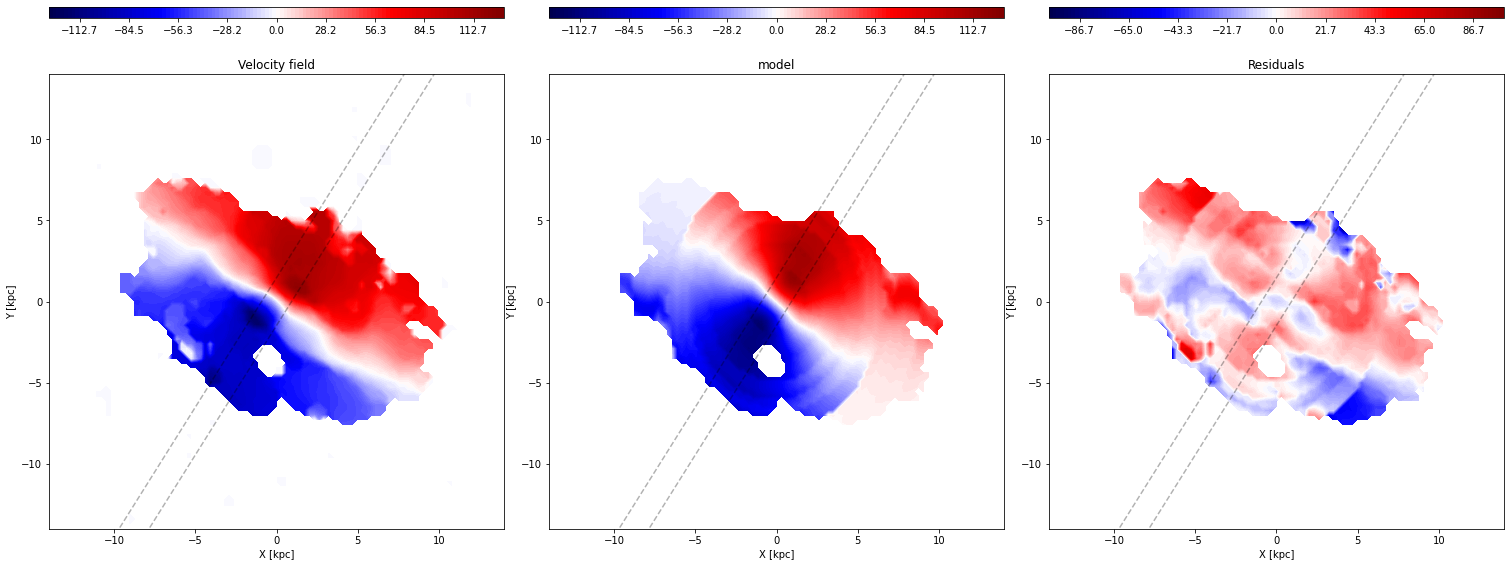

In [70]:
nx= 97#int(np.sqrt(len(R_all)))+7
ny=nx
img_mod=np.nan * np.ones(shape=(nx,nx))
img_vel=np.zeros(shape=(nx,nx))
img_res=np.nan * np.ones(shape=(nx,nx))

for ip, pix in enumerate(coordi):
    ipr=int(pixco[int(2*pix)])
    jpr=int(pixco[int(2*pix+1)])
    if ipr>=img_mod.shape[0] or jpr>=img_mod.shape[1]: break
    img_mod[ipr,jpr]=model[ip]
    img_vel[ipr,jpr]=velim[ip]
    img_res[ipr,jpr]=img_vel[ipr,jpr]-img_mod[ipr,jpr]
img_mod=np.where(masked==0,np.nan,img_mod)

img_mod=np.where(np.isnan(mrk79_mom1),np.nan,img_mod)
#model_cl=np.where(np.isnan(mrk79_mom1),0,model)
img_vel=np.where(np.isnan(mrk79_mom1),np.nan,img_vel)

x=xx_kpc[int(xcen - nx/2 ): int(xcen + nx/2)]
y=yy_kpc[int(ycen - ny/2 ): int(ycen + ny/2)]

model_plot(xx_kpc, yy_kpc, img_vel, img_mod, vmin=-130, vmax=130, resmin=-100, resmax=100,pa=-32.1,levels=121, contour='contourf', cmap='seismic')

In [68]:
mean=np.zeros(shape=(1,5))
for l in range(mean.shape[1]):
    mean[0][l]=np.nanmean(parameters[l,0:10])
mean
print('Mean values of parameters:','\n\nIncl:', mean[0][0], 'pa:',mean[0][1],'A:',mean[0][2],'c:',mean[0][3],'p:', mean[0][4])

Mean values of parameters: 

Incl: 33.460299804015214 pa: 147.87854642696678 A: 282.6253425414366 c: 1.1902837605824974 p: 1.0165327653455551


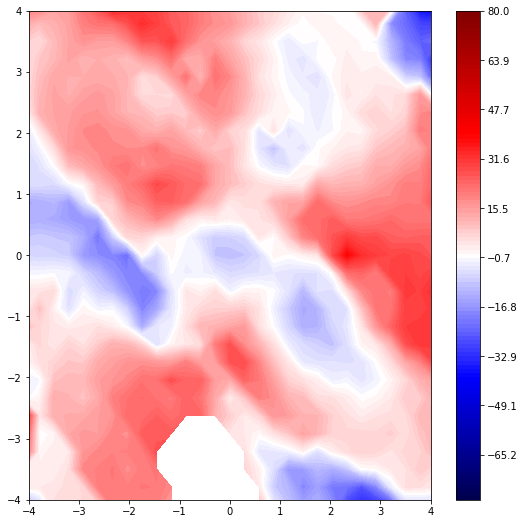

In [69]:
plt.figure(figsize=(9,9))
plt.contourf(xx_kpc,yy_kpc,img_vel-img_mod,cmap='seismic', vmin=-80,vmax=80,levels=np.linspace(-80,80,120))
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.colorbar()

In [65]:
np.sqrt(np.max(xx_kpc)**2+np.max(xx_kpc)**2)
np.max(R_all)

22.048354344481144

In [452]:
20.6113333333*ak

9.543622903668465